In [1]:
import pqr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
prices = pd.read_csv("./data/moex_prices.csv", index_col="Date", parse_dates=True)
volume = pd.read_csv("./data/moex_volume.csv", index_col="Date", parse_dates=True)

In [3]:
evaluate = pqr.freeze(pqr.evaluate, universe_returns=pqr.to_returns(prices))

In [4]:
mom = pqr.compose(
    pqr.freeze(pqr.filter, universe=volume >= 100_000),
    pqr.freeze(pqr.look_back, period=5, agg="pct"),
    pqr.freeze(pqr.lag, period=1),
    pqr.freeze(pqr.hold, period=5),
)(prices)
mom_signals = pqr.quantiles(mom, min_q=0.75, max_q=1)

In [5]:
mom_ew_holdings = pqr.ew(mom_signals)
mom_ew_returns = evaluate(mom_ew_holdings)

In [6]:
mom_smart_beta_holdigns = pqr.allocate(mom_signals, weights=mom+1)
mom_smart_beta_returns = evaluate(mom_smart_beta_holdigns)

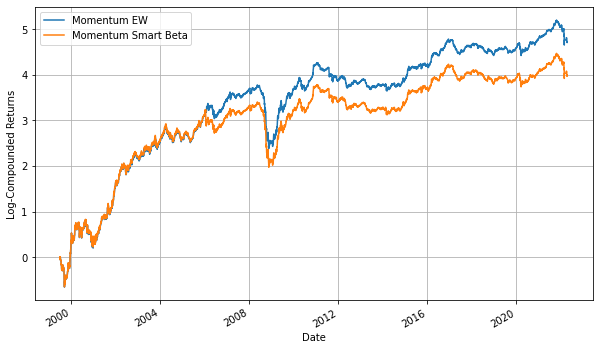

In [7]:
def log_compounded(r: pd.Series) -> pd.Series:
    compounded = (1 + r).cumprod()
    return np.log(compounded)


plt.figure(figsize=(10, 6))

log_compounded(mom_ew_returns).plot(label="Momentum EW")
log_compounded(mom_smart_beta_returns).plot(label="Momentum Smart Beta")

plt.xlabel("Date")
plt.ylabel("Log-Compounded Returns")
plt.grid()
plt.legend(); 

In [8]:
volatility_target = 0.01
volatility = mom_smart_beta_returns.rolling(5).std().shift().iloc[5:]

mom_smart_beta_holdings_scaled = pqr.scale(mom_smart_beta_holdigns, leverage=volatility_target / volatility)
mom_smart_beta_returns_scaled = evaluate(mom_smart_beta_holdings_scaled)

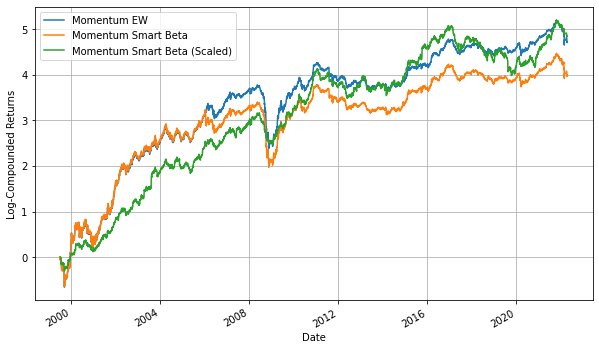

In [9]:
plt.figure(figsize=(10, 6))

log_compounded(mom_ew_returns).plot(label="Momentum EW")
log_compounded(mom_smart_beta_returns).plot(label="Momentum Smart Beta")
log_compounded(mom_smart_beta_returns_scaled).plot(label="Momentum Smart Beta (Scaled)")

plt.xlabel("Date")
plt.ylabel("Log-Compounded Returns")
plt.grid()
plt.legend(); 